# CISI Dataset Information Retrieval Models

In [1]:

import numpy as np
import pandas as pd
import os
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi


## Import and Read files

In [2]:
DOC_FILE = "CISI.ALL"
QUERY_FILE = "CISI.QRY"
REL_FILE = "CISI.REL"

for file_path in [DOC_FILE, QUERY_FILE, REL_FILE]:
    if os.path.exists(file_path):
        print(f"Found file: {file_path}")
    else:
        print(f"File not found: {file_path}")

Found file: CISI.ALL
Found file: CISI.QRY
Found file: CISI.REL


In [3]:
def read_documents(file_path="CISI.ALL"):
    with open(file_path, 'r', encoding='utf-8') as f:
        merged = ""
        for line in f.readlines():
            if line.startswith("."):
                merged += "\n" + line.strip()
            else:
                merged += " " + line.strip()
    
    documents = {}
    content = ""
    doc_id = ""
    
    for line in merged.split("\n"):
        if line.startswith(".I"):
            doc_id = line.split(" ")[1].strip()
        elif line.startswith(".X"):
            if doc_id and content:
                documents[doc_id] = content.strip()
            content = ""
            doc_id = ""
        else:
            content += line.strip()[3:] + " " if line.strip().startswith((".T", ".A", ".W")) else line.strip() + " "
    
    return documents

documents = read_documents()
print(f"Number of documents: {len(documents)}")
print("Sample document (ID 1):", documents.get("1")[:100] + "...") 

Number of documents: 1460
Sample document (ID 1): 18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of th...


In [4]:
def read_queries(file_path="CISI.QRY"):
    with open(file_path, 'r', encoding='utf-8') as f:
        merged = ""
        for line in f.readlines():
            if line.startswith("."):
                merged += "\n" + line.strip()
            else:
                merged += " " + line.strip()
    
    queries = {}
    content = ""
    qry_id = ""
    
    for line in merged.split("\n"):
        if line.startswith(".I"):
            if content and qry_id:
                queries[qry_id] = content.strip()
            content = ""
            qry_id = line.split(" ")[1].strip()
        elif line.startswith((".W", ".T")):
            content += line.strip()[3:] + " "
    
    if content and qry_id: 
        queries[qry_id] = content.strip()
    
    return queries

queries = read_queries()
print(f"Number of queries: {len(queries)}")
print("Sample query (ID 1):", queries.get("1")[:100] + "...")  

Number of queries: 112
Sample query (ID 1): What problems and concerns are there in making up descriptive titles? What difficulties are involved...


In [5]:
def read_mappings(file_path="CISI.REL"):
    mappings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            voc = line.strip().split()
            if len(voc) >= 2:
                key = voc[0].strip()
                doc_id = voc[1].strip()
                if key in mappings:
                    mappings[key].append(doc_id)
                else:
                    mappings[key] = [doc_id]
    return mappings

mappings = read_mappings()
print(f"Number of queries with relevance judgments: {len(mappings)}")
print("Sample mapping (Query ID 1):", mappings.get("1"))

Number of queries with relevance judgments: 76
Sample mapping (Query ID 1): ['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '269', '291', '320', '429', '465', '466', '482', '483', '510', '524', '541', '576', '582', '589', '603', '650', '680', '711', '722', '726', '783', '813', '820', '868', '869', '894', '1162', '1164', '1195', '1196', '1281']


## Preprocessing

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer



In [7]:
def preprocess_text(text):
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [8]:
preprocessed_docs = {doc_id: preprocess_text(text) for doc_id, text in documents.items()}
print(f"Number of preprocessed documents: {len(preprocessed_docs)}")
print("Sample preprocessed document (ID 1):", preprocessed_docs.get("1")[:10]) 

Number of preprocessed documents: 1460
Sample preprocessed document (ID 1): ['18', 'edit', 'dewey', 'decim', 'classif', 'comaromi', 'present', 'studi', 'histori', 'dewey']


In [9]:
preprocessed_queries = {qry_id: preprocess_text(text) for qry_id, text in queries.items()}

print(f"Number of preprocessed queries: {len(preprocessed_queries)}")
print("Sample preprocessed query (ID 1):", preprocessed_queries.get("1")[:10]) 

Number of preprocessed queries: 112
Sample preprocessed query (ID 1): ['problem', 'concern', 'make', 'descript', 'titl', 'difficulti', 'involv', 'automat', 'retriev', 'articl']


## Model A - TF-IDF + Cosine Similarity

In [10]:
import numpy as np

doc_texts = [' '.join(tokens) for tokens in preprocessed_docs.values()]
vectorizer = TfidfVectorizer(analyzer='word', lowercase=False)
tfidf_matrix = vectorizer.fit_transform(doc_texts)

query_texts = [' '.join(tokens) for tokens in preprocessed_queries.values()]
query_tfidf = vectorizer.transform(query_texts)

similarities = cosine_similarity(query_tfidf, tfidf_matrix)

# Rank documents for each query
doc_ids = list(preprocessed_docs.keys())
model_a_results = {}
for i, qry_id in enumerate(preprocessed_queries.keys()):
    scores = similarities[i]
    ranked_indices = np.argsort(scores)[::-1][:10]  # Top 10 documents
    ranked_docs = [doc_ids[idx] for idx in ranked_indices]
    model_a_results[qry_id] = ranked_docs

print("Model A: Top 5 documents for Query 1:", model_a_results.get("1")[:5])

Model A: Top 5 documents for Query 1: ['722', '429', '589', '1281', '603']


## Model B - SMART Notation TF-IDF

In [11]:
smart_vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', lowercase=False)
smart_tfidf_matrix = smart_vectorizer.fit_transform(doc_texts)

smart_query_tfidf = smart_vectorizer.transform(query_texts)

smart_similarities = cosine_similarity(smart_query_tfidf, smart_tfidf_matrix)

# Rank documents
model_b_results = {}
for i, qry_id in enumerate(preprocessed_queries.keys()):
    scores = smart_similarities[i]
    ranked_indices = np.argsort(scores)[::-1][:10]
    ranked_docs = [doc_ids[idx] for idx in ranked_indices]
    model_b_results[qry_id] = ranked_docs

print("Model B: Top 5 documents for Query 1:", model_b_results.get("1")[:5])

Model B: Top 5 documents for Query 1: ['429', '1281', '722', '1299', '711']


## Model C - BM25

In [12]:
from rank_bm25 import BM25Okapi

bm25 = BM25Okapi(list(preprocessed_docs.values()), k1=1.5, b=0.75)

model_c_results = {}
for qry_id, query_tokens in preprocessed_queries.items():
    scores = bm25.get_scores(query_tokens)
    ranked_indices = np.argsort(scores)[::-1][:10]
    ranked_docs = [doc_ids[idx] for idx in ranked_indices]
    model_c_results[qry_id] = ranked_docs

print("Model C: Top 5 documents for Query 1:", model_c_results.get("1")[:5])

Model C: Top 5 documents for Query 1: ['429', '722', '1299', '759', '65']


## Evaluate Models

In [13]:
def evaluate_model(results, mappings):
    precisions = []
    recalls = []
    for qry_id, ranked_docs in results.items():
        if qry_id in mappings:
            relevant_docs = set(mappings[qry_id])
            retrieved_docs = set(ranked_docs)
            true_positives = len(retrieved_docs & relevant_docs)
            precision = true_positives / len(retrieved_docs) if retrieved_docs else 0
            recall = true_positives / len(relevant_docs) if relevant_docs else 0
            precisions.append(precision)
            recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

models = {
    "Model A (TF-IDF)": model_a_results,
    "Model B (SMART)": model_b_results,
    "Model C (BM25)": model_c_results
}
results = {}
for model_name, model_results in models.items():
    avg_precision, avg_recall = evaluate_model(model_results, mappings)
    results[model_name] = {"Precision": avg_precision, "Recall": avg_recall}

print("Evaluation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")

Evaluation Results:
Model A (TF-IDF): Precision = 0.3526, Recall = 0.1314
Model B (SMART): Precision = 0.3658, Recall = 0.1433
Model C (BM25): Precision = 0.3684, Recall = 0.1531


## Visualize Results (Using Matplotlib)

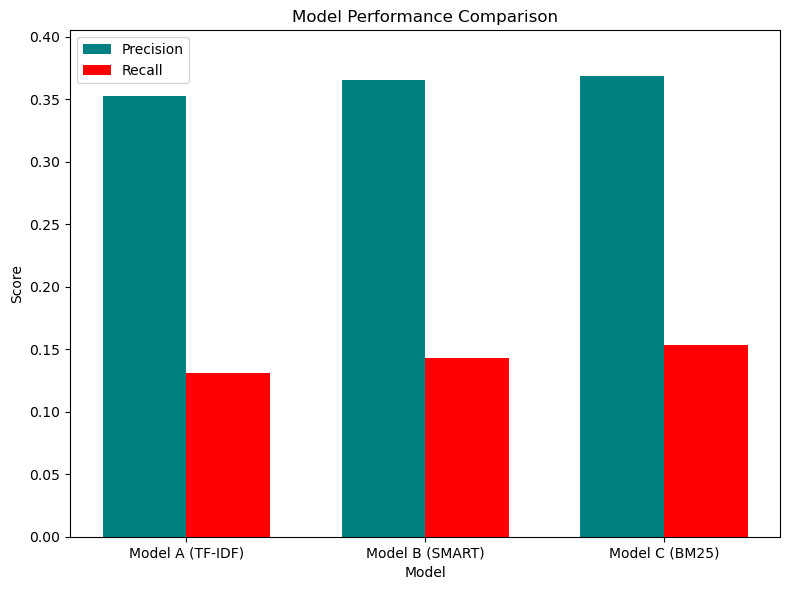

In [14]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Model A (TF-IDF)', 'Model B (SMART)', 'Model C (BM25)']
precisions = [0.3526, 0.3658, 0.3684]
recalls = [0.1314, 0.1433, 0.1531]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, precisions, width, label='Precision', color='teal')
rects2 = ax.bar(x + width/2, recalls, width, label='Recall', color='red')

ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_ylim(0, max(max(precisions), max(recalls)) * 1.1)

plt.tight_layout()
plt.show()